In [94]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [95]:
# df_world = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df_world = pd.read_csv('../data/owid-covid-data.csv')
df_world['d_o_y'] = pd.DatetimeIndex(df_world['date']).dayofyear
df_world.drop(df_world[df_world['date']=='2019-12-31'].index, axis=0, inplace=True)

In [91]:
df_world.drop(df_world[df_world['date']=='2019-12-31'].index, axis=0, inplace=True)

In [92]:
df_world[(df_world['date']=='2019-12-31') & (df_world['total_cases']!=0)]

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,d_o_y


In [96]:
df_world.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,d_o_y
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,73
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,80
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,84
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,85
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,86


In [97]:
df_world[df_world.new_cases < 0]

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,d_o_y
4555,ECU,Ecuador,2020-05-07,29420,-2461,1618,49,1667.511,-139.488,91.707,2.777,44373.0,1503.0,2.515,0.085,samples tested,17643060.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.50,128
4557,ECU,Ecuador,2020-05-09,28818,-1480,1704,50,1633.390,-83.886,96.582,2.834,NaN,NaN,NaN,NaN,NaN,17643060.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.50,130
4866,ESP,Spain,2020-04-19,188578,-1430,20453,410,4033.341,-30.585,437.453,8.769,NaN,NaN,NaN,NaN,NaN,46754783.0,93.105,45.5,19.436,13.799,34272.360,1.0,99.403,7.17,27.4,31.4,NaN,2.97,110
9574,LTU,Lithuania,2020-04-29,1344,-105,44,3,493.702,-38.570,16.163,1.102,118201.0,6392.0,43.420,2.348,samples tested,2722291.0,45.135,43.5,19.002,13.778,29524.265,0.7,342.989,3.67,21.3,38.0,NaN,6.56,120
12717,PRT,Portugal,2020-05-03,25190,-161,1023,16,2470.405,-15.789,100.327,1.569,458702.0,8458.0,44.985,0.829,samples tested,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,124
13973,SMR,San Marino,2020-05-11,628,-9,41,0,18504.331,-265.189,1208.085,0.000,NaN,NaN,NaN,NaN,NaN,33938.0,556.667,NaN,NaN,NaN,56861.470,NaN,NaN,5.64,NaN,NaN,NaN,3.80,132
16591,NaN,International,2020-03-10,696,-9,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70


In [9]:
df_usa = pd.read_csv('../data/us_states_covid19_daily.csv')

In [10]:
df_usa.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200510,AK,379.0,26985.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,27364,27364,27364,2,0.0,0.0,914.0,1.0,915.0
1,20200510,AL,9777.0,117644.0,NaN,NaN,1240.0,NaN,460.0,NaN,...,1240.0,127421,127421,127421,1,5.0,12.0,1717.0,210.0,1927.0
2,20200510,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,471.0,65528,65528,65528,5,0.0,0.0,0.0,0.0,0.0
3,20200510,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,20200510,AZ,11119.0,126620.0,NaN,713.0,1528.0,300.0,NaN,195.0,...,1528.0,137739,137739,137739,4,4.0,14.0,8640.0,159.0,8799.0


In [12]:
pd.unique(df_world['iso_code'])

array(['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA',
       'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL',
       'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL',
       'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI',
       'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK',
       'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'GAB', 'GBR', 'GEO', 'GGY',
       'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL',
       'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MKD',
       'MLI', 'MLT',

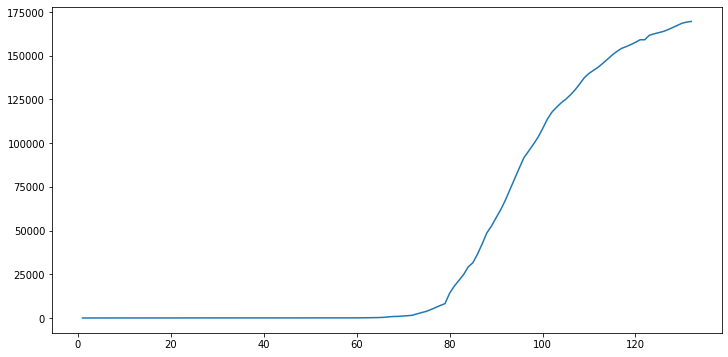

In [83]:
iso_code = 'DEU'
df3 = df_world[df_world['iso_code']==iso_code]
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.d_o_y, df3.total_cases)
# ax.set_yscale('log')

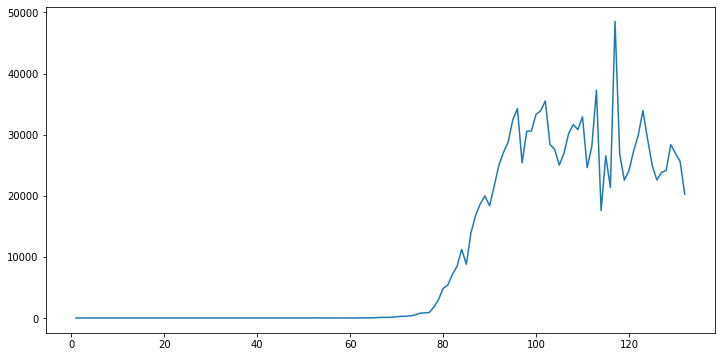

In [84]:
iso_code = 'USA'
df3 = df_world[df_world['iso_code']==iso_code]
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.d_o_y, df3.new_cases)

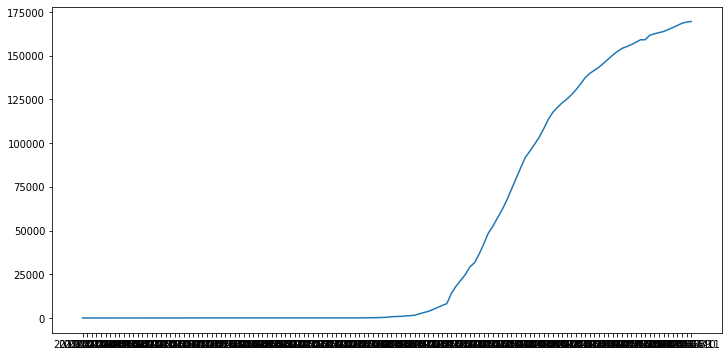

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.date, df3.total_cases)

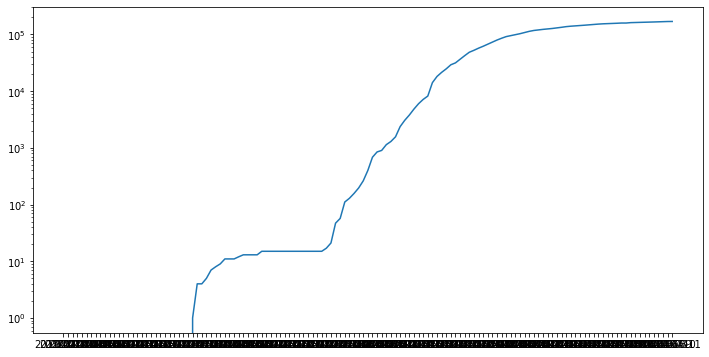

In [25]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.date, df3.total_cases)
ax.set_yscale('log')

In [98]:
countries_list = ['China', 'South Korea', 'Italy', 'Iran', 'Spain', 'Germany', 'France', 
                  'United Kingdom', 'Switzerland',  'United States', 'Russia']

In [ ]:
df_world[(df_world['date']=='2020-05-11') & df_world['location']

In [75]:
import os
from operator import itemgetter
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# constants
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
colors = {
  'very_light_gray': '#ececec',
  'light_gray': '#b6b6b6',
  'medium_gray': '#929292',
  'very_dark_gray': '#414141',
  'orange': '#ff6f00',
  'light_blue': '#79c3ff',
  'light_purple': '#d88aff',
  'light_green': '#b4ec70',
  'light_yellow': '#fff27e',
  'light_red': '#ff7482',
  'light_cyan': '#84ffff',
    'black' : '#000000'
}
start_date = np.datetime64('2020-01-22')
all_dates = [start_date + np.timedelta64(x, 'D') for x in range(0, 161)]

In [76]:
def convert_to_ts (data, country):
  df = data[data['location'] == country].groupby(['date'], as_index=False)['total_cases'].sum()
  df.columns = ['date', 'count']
  df['date'] = df['date'].astype('datetime64[ns]')
  return df

data = pd.read_csv('../data/owid-covid-data.csv')
dat = [
  { 'name': 'China', 'color': 'light_gray' },
  { 'name': 'South Korea', 'color': 'medium_gray' },
  { 'name': 'Italy', 'color': 'very_dark_gray' },
  { 'name': 'Iran', 'color': 'light_blue' },
  { 'name': 'Spain', 'color': 'light_purple' },
  { 'name': 'Germany', 'color': 'light_green' },
  { 'name': 'France', 'color': 'light_yellow' },
  { 'name': 'United Kingdom', 'color': 'light_red' },
  { 'name': 'Switzerland', 'color': 'light_cyan' },
  { 'name': 'United States', 'color': 'orange' },
  { 'name': 'Russia', 'color': 'black' }
]
countries = { d['name']: convert_to_ts(data, d['name']) for d in dat}

In [77]:
countries

{'China':           date  count
 0   2019-12-31     27
 1   2020-01-01     27
 2   2020-01-02     27
 3   2020-01-03     44
 4   2020-01-04     44
 5   2020-01-05     59
 6   2020-01-06     59
 7   2020-01-07     59
 8   2020-01-08     59
 9   2020-01-09     59
 10  2020-01-10     59
 11  2020-01-11     59
 12  2020-01-12     59
 13  2020-01-13     59
 14  2020-01-14     59
 15  2020-01-15     59
 16  2020-01-16     59
 17  2020-01-17     63
 18  2020-01-18     80
 19  2020-01-19    216
 20  2020-01-20    235
 21  2020-01-21    386
 22  2020-01-22    526
 23  2020-01-23    623
 24  2020-01-24    882
 25  2020-01-25   1323
 26  2020-01-26   1988
 27  2020-01-27   2775
 28  2020-01-28   4528
 29  2020-01-29   5994
 30  2020-01-30   7734
 31  2020-01-31   9714
 32  2020-02-01  11809
 33  2020-02-02  14399
 34  2020-02-03  17211
 35  2020-02-04  20448
 36  2020-02-05  24320
 37  2020-02-06  28047
 38  2020-02-07  31207
 39  2020-02-08  34625
 40  2020-02-09  37232
 41  2020-02-10  40206
 4

In [78]:
pd.DataFrame(
  map(lambda obj: [obj[0], f'{obj[1]["count"].max():,.0f}'], countries.items()),
  columns=['Country', 'Max infected']
)

,Country,Max infected
0,China,"84,010"
1,South Korea,"10,909"
2,Italy,"219,070"
3,Iran,"107,603"
4,Spain,"224,390"
5,Germany,"169,575"
6,France,"139,063"
7,United Kingdom,"219,183"
8,Switzerland,"30,222"
9,United States,"1,329,799"


In [79]:
def comparison_to_china_penalty (df, offset):
  china_counts = countries['China']['count'].to_numpy()
  counts = df['count'].to_numpy()
  residuals = []
  for i in range(0, 14):
    if i + offset < len(counts):
      residuals.append(china_counts[i] - counts[i + offset])
    else:
      residuals.append(0)
  return np.power(residuals, 2).sum()

def find_optimal_offset (df):
  penalties = []
  for offset in range(len(df)):
    penalties.append(comparison_to_china_penalty(df, offset))
  return np.argmin(penalties)

for d in dat:
  d['offset'] = find_optimal_offset(countries[d['name']])
dat.sort(key=lambda x: x['offset'])

In [80]:
dat

[{'name': 'China', 'color': 'light_gray', 'offset': 0},
 {'name': 'South Korea', 'color': 'medium_gray', 'offset': 38},
 {'name': 'Italy', 'color': 'very_dark_gray', 'offset': 41},
 {'name': 'Iran', 'color': 'light_blue', 'offset': 44},
 {'name': 'Germany', 'color': 'light_green', 'offset': 47},
 {'name': 'France', 'color': 'light_yellow', 'offset': 48},
 {'name': 'United States', 'color': 'orange', 'offset': 49},
 {'name': 'Spain', 'color': 'light_purple', 'offset': 50},
 {'name': 'United Kingdom', 'color': 'light_red', 'offset': 52},
 {'name': 'Switzerland', 'color': 'light_cyan', 'offset': 53},
 {'name': 'Russia', 'color': 'black', 'offset': 64}]

In [81]:
pd.DataFrame(dat, columns=['name', 'offset'])

,name,offset
0,China,0
1,South Korea,38
2,Italy,41
3,Iran,44
4,Germany,47
5,France,48
6,United States,49
7,Spain,50
8,United Kingdom,52
9,Switzerland,53


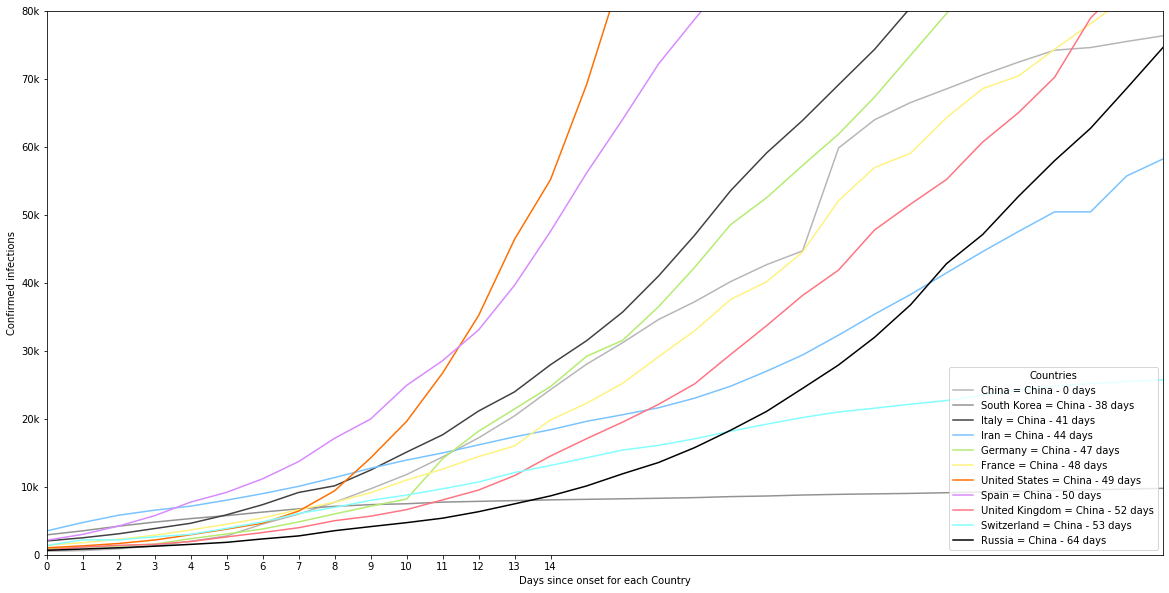

In [82]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for d in dat:
  country_name, offset, color_key = itemgetter('name', 'offset', 'color')(d)
  country = countries[country_name]
  ax.plot(
    country['date'] - np.timedelta64(offset, 'D'),
    country['count'],
    label=f'{country_name} = China - {offset} days',
    color=colors[color_key]
  )

plt.xlim((np.datetime64('2020-01-22'), np.datetime64('2020-02-22')))
plt.xticks([np.datetime64('2020-01-22') + np.timedelta64(d, 'D') for d in range(0, 15)])
ax.set_xticklabels(range(0, 15))
plt.xlabel('Days since onset for each Country')

plt.ylim((0, 80000))
ax.set_yticklabels(['0' if x == 0 else '{:.0f}k'.format(int(x) / 1000) for x in ax.get_yticks().tolist()])
plt.ylabel('Confirmed infections')

plt.legend(title='Countries', loc='lower right')

plt.show();

In [83]:
def sigmoid (x, A, slope, offset):
  return A / (1 + np.exp ((x - (offset + 17.75)) / slope))

def fit_to_sigmoid (df, offset, all_dates):
  dates = (df['date'] - start_date) / np.timedelta64(1, 'D')
  p, _ = curve_fit(
    lambda x, A, slope: sigmoid(x, A, slope, offset),
    dates,
    df['count'],
    p0=[80000, -5],
    bounds=(
      [-np.inf, -np.inf],
      [np.inf, -0.01]
    ),
    maxfev=5000,
  )
  return sigmoid((all_dates - start_date) / np.timedelta64(1, 'D'), *p, offset), p

for d in dat:
  country_name, offset, color_key = itemgetter('name', 'offset', 'color')(d)
  country = countries[country_name]
  fit, p = fit_to_sigmoid(country, offset, all_dates)
  d['fit'] = fit
  d['p'] = p

In [84]:
dat

[{'name': 'China',
  'color': 'light_gray',
  'offset': 0,
  'fit': array([ 1699.44275111,  2101.26093987,  2595.0174159 ,  3200.15359016,
          3939.40664307,  4838.95206965,  5928.31635639,  7239.92900421,
          8808.15499971, 10667.63734637, 12850.80398326, 15384.47901616,
         18285.70689525, 21557.15440221, 25182.76434147, 29124.60606045,
         33321.96223256, 37693.47118784, 42142.56135853, 46565.58896513,
         50861.30642415, 54939.87481885, 58729.77760287, 62181.62802391,
         65268.70965942, 67984.82028812, 70340.39400639, 72357.92552886,
         74067.51881735, 75503.07708155, 76699.36095444, 77689.92780439,
         78505.84011384, 79174.97889207, 79721.79433845, 80167.34778653,
         80529.53022212, 80823.37387892, 81061.40006081, 81253.96703378,
         81409.59684211, 81535.27019419, 81636.68524975, 81718.48023432,
         81784.42212227, 81837.56477985, 81880.3803771 , 81914.86786167,
         81942.64203271, 81965.00638491, 81983.01248702, 8

In [85]:
china_slope = dat[0]['p'][1]
growth_rate_relative_to_china = lambda p: china_slope/p[1]

table_data = []
for d in dat:
  country_name, offset, p = itemgetter('name', 'offset', 'p')(d)
  # name, days behind china, relative growth rate, max infected
  table_data.append([
    country_name, 
    '' if country_name == 'China' else f'{offset}',
    f'{growth_rate_relative_to_china(p):.1f}',
    f'{p[0]:,.0f}'
  ])

pd.DataFrame(table_data, columns=['Country', 'Days behind China', 
                                  'Growth rate relative to China', 'Estimated max infected'])

,Country,Days behind China,Growth rate relative to China,Estimated max infected
0,China,,1.0,"82,057"
1,South Korea,38,0.3,"12,473"
2,Italy,41,0.6,"172,706"
3,Iran,44,0.5,"83,227"
4,Germany,47,0.7,"140,690"
5,France,48,0.7,"114,070"
6,United States,49,0.6,"850,923"
7,Spain,50,0.8,"197,484"
8,United Kingdom,52,0.6,"142,078"
9,Switzerland,53,0.6,"30,432"


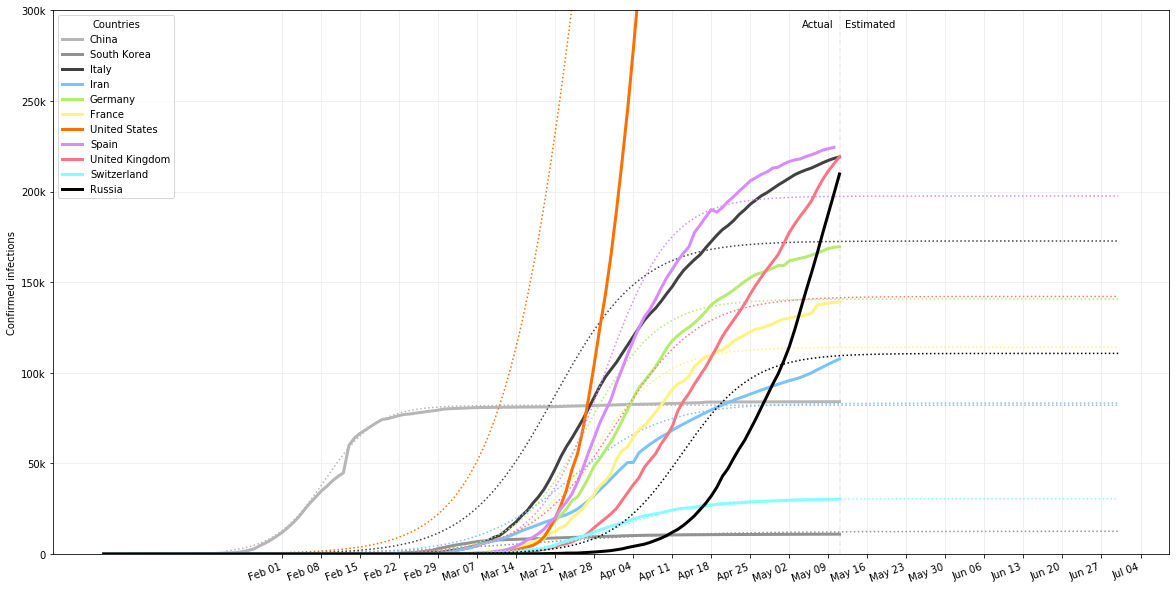

In [86]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for d in dat:
  country_name, color_key, fit = itemgetter('name', 'color', 'fit')(d)
  country = countries[country_name]
  ax.plot(
    country['date'],
    country['count'],
    label=country_name,
    color=colors[color_key],
    linewidth=3
  )
  ax.plot(
    all_dates,
    fit,
    color=colors[color_key],
    linestyle=':'
  )

# plots the "now" line
y_max = 300000
now = np.datetime64('2020-05-11').astype('datetime64[D]')
plt.vlines(now, ymin=0, ymax=y_max, colors=colors['very_light_gray'], linestyles='dashed')
plt.annotate('Actual', xy=(now - np.timedelta64(1, 'D'), y_max - 5000), ha='right', va='top')
plt.annotate('Estimated', xy=(now + np.timedelta64(1, 'D'), y_max - 5000), ha='left', va='top')

ticks = [np.datetime64('2020-02-01') + np.timedelta64(7 * x, 'D') for x in range(0, 23)]
label_from_tick = lambda tick: pd.to_datetime(tick).strftime('%b %d')
tick_labels = list(map(label_from_tick, ticks))
plt.xticks(ticks, tick_labels, rotation=20, horizontalalignment='right')

plt.ylim((0, y_max))
ax.set_yticklabels(['0' if x == 0 else '{:.0f}k'.format(int(x) / 1000) for x in ax.get_yticks().tolist()])
plt.ylabel('Confirmed infections')

plt.grid(color=colors['very_light_gray'])

plt.legend(title='Countries', loc='upper left')

plt.show();